### Практическое задание №3. Классификация мест залежей нефти и газа

Нефтегазовая отрасль имеет сложную технологическую цепочку, которая начинается с геологической разведки и заканчивается доставкой нефти и газа потребителям. Одной из важных задач является определение места залежей — на суше или в море — на основе различных параметров.

**Задача:** разработать алгоритм машинного обучения, который позволит классифицировать место залежей нефти и газа.

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Аутентификация на Kaggle
api = KaggleApi()
api.authenticate()

# Загрузка данных c Kaggle
competition_name = "classification-of-oil-and-gas-fields"
api.competition_download_files(competition_name)

with zipfile.ZipFile(f"{competition_name}.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Удаление архива после распаковки
os.remove(f"{competition_name}.zip")

In [ ]:
train_df = pd.read_csv("data/train_oil.csv")
test_df = pd.read_csv("data/oil_test.csv")

# Выводим форму датасетов, чтобы понять количество строк и столбцов
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (309, 20)
Test dataset shape: (133, 19)


**Columns**  
  
Каждое месторождение обладает 19 параметрами:  
   
- `Field name` - название месторождения
- `Reservoir unit` - юнит месторождения
- `Country` - страна расположения
- `Region` - регион расположения
- `Basin name` - название бассейна пород
- `Tectonic regime` - тектонический режим
- `Latitude` - широта
- `Longitude` - долгота
- `Operator company` - название компании
- `Onshore` or `oﬀshore` - целевая переменная (ONSHORE - 1, OFFSHORE - 0, ONSHORE-OFFSHORE - 2)
- `Hydrocarbon type` (main) - тип углеводорода
- `Reservoir status` (current) - статус месторождения
- `Structural setting` - структурные свойства
- `Depth` (top reservoir ft TVD) - глубина
- `Reservoir period` - литологический период
- `Lithology` (main) - литология
- `Thickness (gross average ft)` - общая толщина
- `Thickness (net pay average ft)` - эффективная толщина
- `Porosity` (matrix average 20. `Permeability` (air average mD)) – проницаемость

In [ ]:
train_df

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,HIDES,IMBURU-TORO,PAPUA NEW GUINEA,FAR EAST,PAPUAN FTB,COMPRESSION,-6.0136,142.8409,OIL SEARCH LTD,ONSHORE,GAS-CONDENSATE,CONTINUING DEVELOPMENT,THRUST,9905,JURASSIC-CRETACEOUS,SANDSTONE,490.0,240.0,10.0,100.0
305,DRAKE POINT,DRAKE POINT-INTREPID INLET,CANADA,NORTH AMERICA,SVERDRUP,COMPRESSION/EVAPORITE/EXTENSION/LINKED,76.4462,-108.9172,PANARCTIC OILS,ONSHORE,GAS,UNDEVELOPED,FORELAND,3390,JURASSIC,SANDSTONE,100.0,71.0,20.0,566.0
306,ALTAMONT-BLUEBELL,GREEN RIVER AND COLTON/WASATCH,USA,NORTH AMERICA,UINTA,COMPRESSION,40.3000,-110.2100,NUMEROUS,ONSHORE,OIL,MATURE PRODUCTION,FORELAND,15250,PALEOGENE,SANDSTONE,8000.0,575.0,5.0,0.1
307,BELL CREEK,MUDDY,USA,NORTH AMERICA,POWDER RIVER,COMPRESSION,45.1039,-105.0967,SAMUEL GARY,ONSHORE,OIL,NEARLY DEPLETED,FORELAND,4300,CRETACEOUS,SANDSTONE,45.0,23.0,28.5,2250.0


In [ ]:
# Получить информацию об обучающем наборе данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [ ]:
# Получить информацию о тестовом наборе данных
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      133 non-null    object 
 1   Reservoir unit                  133 non-null    object 
 2   Country                         120 non-null    object 
 3   Region                          117 non-null    object 
 4   Basin name                      125 non-null    object 
 5   Tectonic regime                 133 non-null    object 
 6   Latitude                        120 non-null    float64
 7   Longitude                       117 non-null    float64
 8   Operator company                133 non-null    object 
 9   Hydrocarbon type                133 non-null    object 
 10  Reservoir status                133 non-null    object 
 11  Structural setting              133 non-null    object 
 12  Depth                           133 

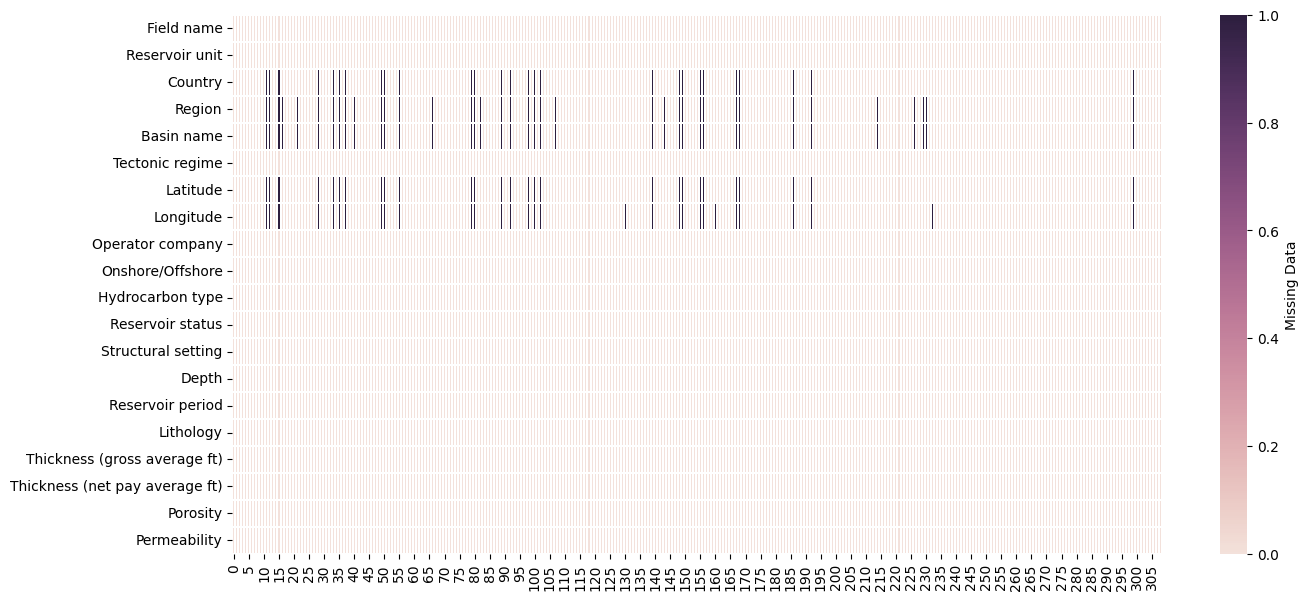

In [ ]:
# Визуализировать пропуски в данных с помощью тепловой карты
plt.figure(figsize=(15,7))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(train_df.isna().transpose(), cmap=cmap,
            cbar_kws={'label': 'Missing Data'}, linewidths=0.05)
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

In [ ]:
# Удалить пропущенные значения в обоих наборах данных
train_df = train_df.dropna()

# Заменить отсутствующие значения с помощью SimpleImputer
# num_imr = SimpleImputer(missing_values=np.nan, strategy='mean')
# cat_imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# numeric_cols = ['Latitude', 'Longitude']
# categorial_cols = ['Country', 'Region', 'Basin name']

# train_df[numeric_cols] = num_imr.fit_transform(train_df[numeric_cols])
# train_df[categorial_cols] = cat_imr.fit_transform(train_df[categorial_cols])
#test_df[numeric_cols] = num_imr.fit_transform(test_df[numeric_cols])
#test_df[categorial_cols] = cat_imr.fit_transform(test_df[categorial_cols])

C:\Users\ludkov-as\AppData\Local\Temp\ipykernel_16504\2326606398.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')


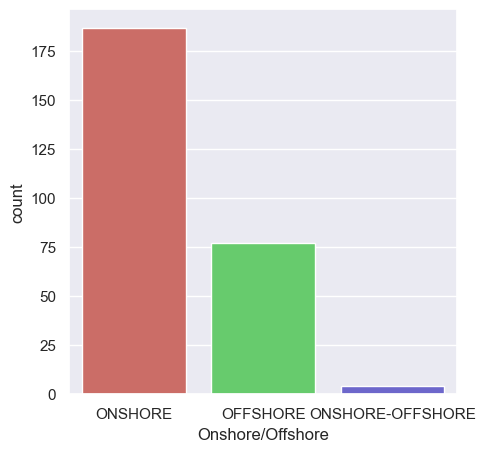

In [ ]:
# Проверка дисбаланса классов
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(train_df['Onshore/Offshore'])
sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')
plt.show()

In [ ]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

categorial_cols = ['Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 
                   'Tectonic regime', 'Structural setting', 'Field name', 'Reservoir unit', 
                   'Country', 'Region', 'Basin name', 'Operator company']
# categorial_cols = ['Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology']
train_df[categorial_cols] = oe.fit_transform(train_df[categorial_cols])
test_df[categorial_cols] = oe.fit_transform(test_df[categorial_cols])

# encode_train = oe.fit_transform(train_df[categorial_cols])
# encode_test = oe.fit_transform(test_df[categorial_cols])
# train_df[categorial_cols] = encode_train
# test_df[categorial_cols] = encode_test

In [ ]:
# Перенести метки классов в конец обучающего набора данных
#train_df['Onshore/Offshore'] = train_df.pop('Onshore/Offshore')
# le = LabelEncoder()

# Преобразовать метки классов числовыми значениями с помощью LabelEncoder
# train_df['Onshore/Offshore'] = le.fit_transform(train_df['Onshore/Offshore'])
#le.classes_
#le.transform(['ONSHORE', 'OFFSHORE', 'ONSHORE-OFFSHORE'])

d = {'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2}
train_df['Onshore/Offshore'] = train_df['Onshore/Offshore'].map(d)

In [ ]:
print(train_df.info())
print(train_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      268 non-null    float64
 1   Reservoir unit                  268 non-null    float64
 2   Country                         268 non-null    float64
 3   Region                          268 non-null    float64
 4   Basin name                      268 non-null    float64
 5   Tectonic regime                 268 non-null    float64
 6   Latitude                        268 non-null    float64
 7   Longitude                       268 non-null    float64
 8   Operator company                268 non-null    float64
 9   Onshore/Offshore                268 non-null    int64  
 10  Hydrocarbon type                268 non-null    float64
 11  Reservoir status                268 non-null    float64
 12  Structural setting              268 non-n

In [ ]:
train_df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,250.0,119.0,26.0,3.0,85.0,4.0,51.0000,44.8042,68.0,1,3.0,2.0,5.0,1870,1.0,7.0,262.0,33.0,24.0,30.0
1,121.0,96.0,3.0,4.0,20.0,17.0,-19.6017,-39.8332,80.0,1,3.0,6.0,15.0,4843,13.0,7.0,2133.0,72.0,23.0,350.0
2,0.0,14.0,27.0,5.0,80.0,4.0,26.0800,49.8100,93.0,1,3.0,8.0,5.0,6050,8.0,5.0,250.0,184.0,21.0,410.0
3,150.0,34.0,37.0,1.0,50.0,17.0,61.3833,1.7500,30.0,0,3.0,6.0,16.0,8988,8.0,7.0,425.0,300.0,22.0,750.0
4,233.0,132.0,4.0,6.0,87.0,0.0,53.2287,-115.8008,70.0,1,3.0,12.0,5.0,9306,5.0,3.0,233.0,167.0,11.8,1407.0


Детерминант корреляционной матрицы: 0.012352463140800594;
Ранг корреляционной матрицы: 20


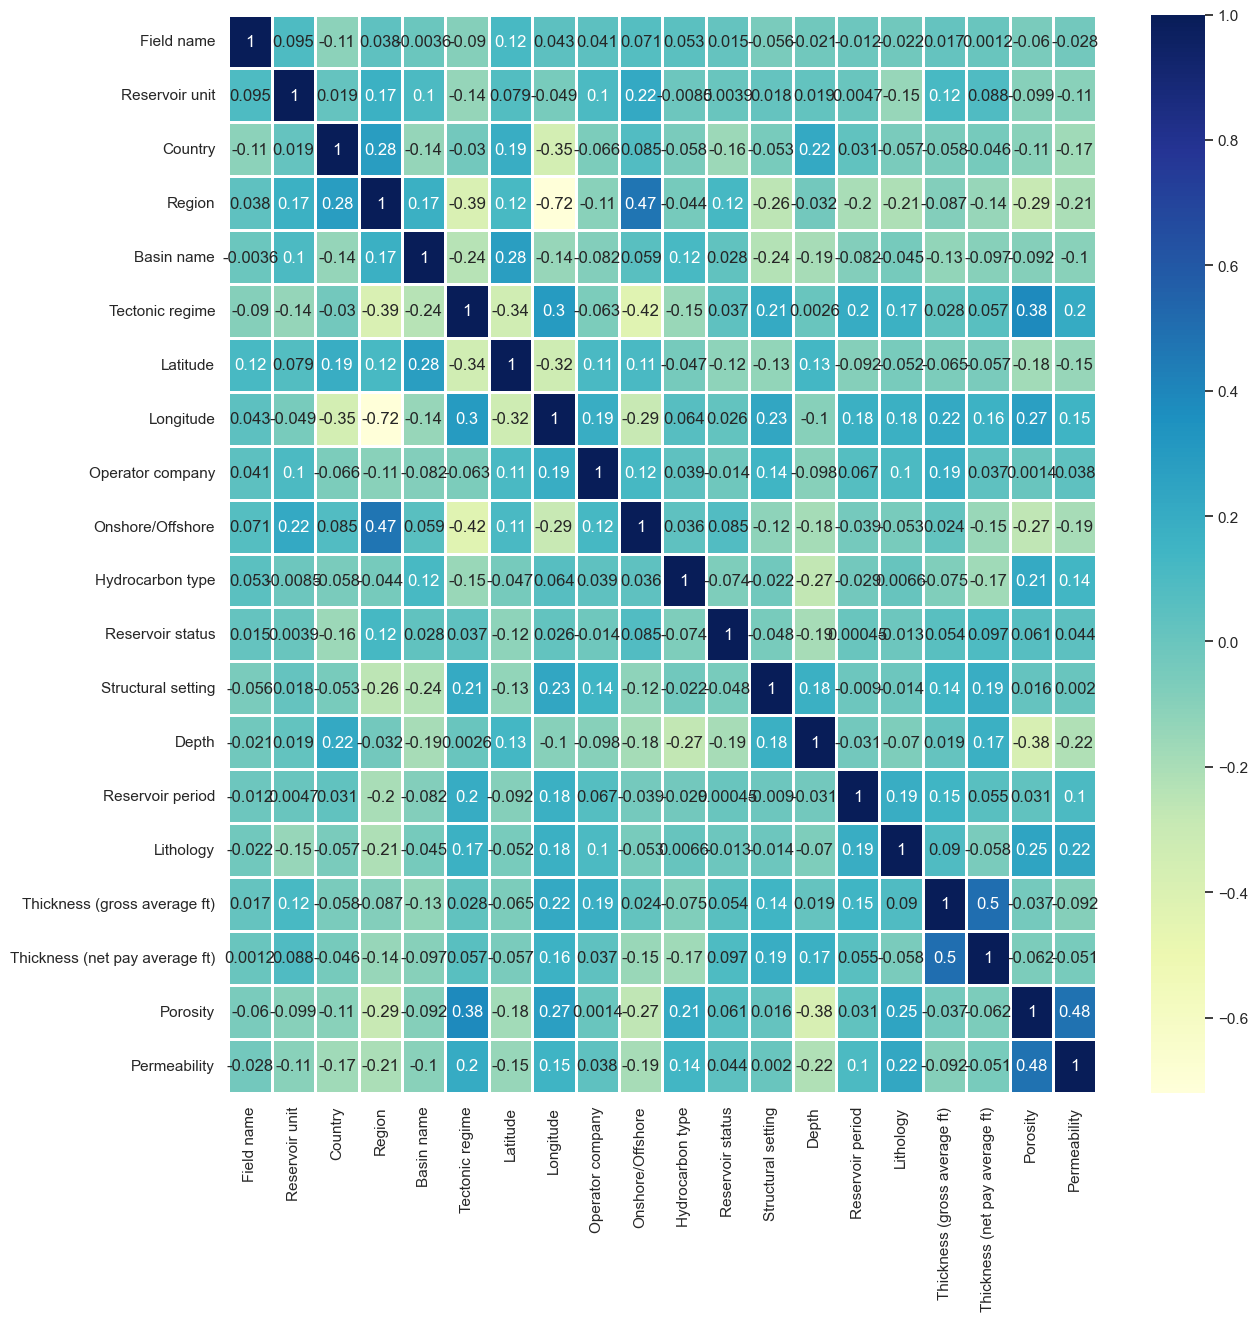

In [ ]:
# Построить корреляционную матрицу обучающего набора данных
corr_matrix = train_df.corr(numeric_only=True)
sns.set(rc = {'figure.figsize':(14, 14)})

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", linecolor='white', linewidths=1)

# Вычислить детерминант
det = np.linalg.det(corr_matrix)

# Вычислить ранг корреляционной матрицы
rank = np.linalg.matrix_rank(corr_matrix)

print(f"Детерминант корреляционной матрицы: {det};\nРанг корреляционной матрицы: {rank}")

In [ ]:
drop_column = ['Field name', 'Country', 'Basin name', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)']
train_df = train_df.drop(drop_column, axis=1)
test_df = test_df.drop(drop_column,axis=1)

In [ ]:
#X = train_df[train_df.columns[:-1]]
X = train_df.drop(columns=['Onshore/Offshore'])
y = train_df['Onshore/Offshore']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 308
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Reservoir unit                  268 non-null    float64
 1   Region                          268 non-null    float64
 2   Tectonic regime                 268 non-null    float64
 3   Latitude                        268 non-null    float64
 4   Longitude                       268 non-null    float64
 5   Operator company                268 non-null    float64
 6   Structural setting              268 non-null    float64
 7   Depth                           268 non-null    int64  
 8   Thickness (net pay average ft)  268 non-null    float64
 9   Porosity                        268 non-null    float64
 10  Permeability                    268 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 25.1 KB


In [ ]:
y.value_counts()

Onshore/Offshore
1    187
0     77
2      4
Name: count, dtype: int64

In [ ]:
# Осуществить балансировку классов с помощью SMOTE
os = SMOTE(random_state=0, k_neighbors=2)
columns = X.columns
os_data_X, os_data_y = os.fit_resample(X, y)

os_data_X = pd.DataFrame(os_data_X, columns = columns)
os_data_y = pd.DataFrame(os_data_y, columns = ['Onshore/Offshore'])

print(f'Features shape after SMOTE: {os_data_X.shape}')
print(f'Classes distribution after SMOTE:\n{os_data_y.value_counts()}')

Features shape after SMOTE: (561, 11)
Classes distribution after SMOTE:
Onshore/Offshore
0                   187
1                   187
2                   187
Name: count, dtype: int64


 1) Tectonic regime                0.210223
 2) Longitude                      0.127554
 3) Region                         0.119155
 4) Latitude                       0.103912
 5) Thickness (net pay average ft) 0.085685
 6) Structural setting             0.072889
 7) Depth                          0.069044
 8) Operator company               0.066037
 9) Reservoir unit                 0.049928
10) Porosity                       0.049549
11) Permeability                   0.046024


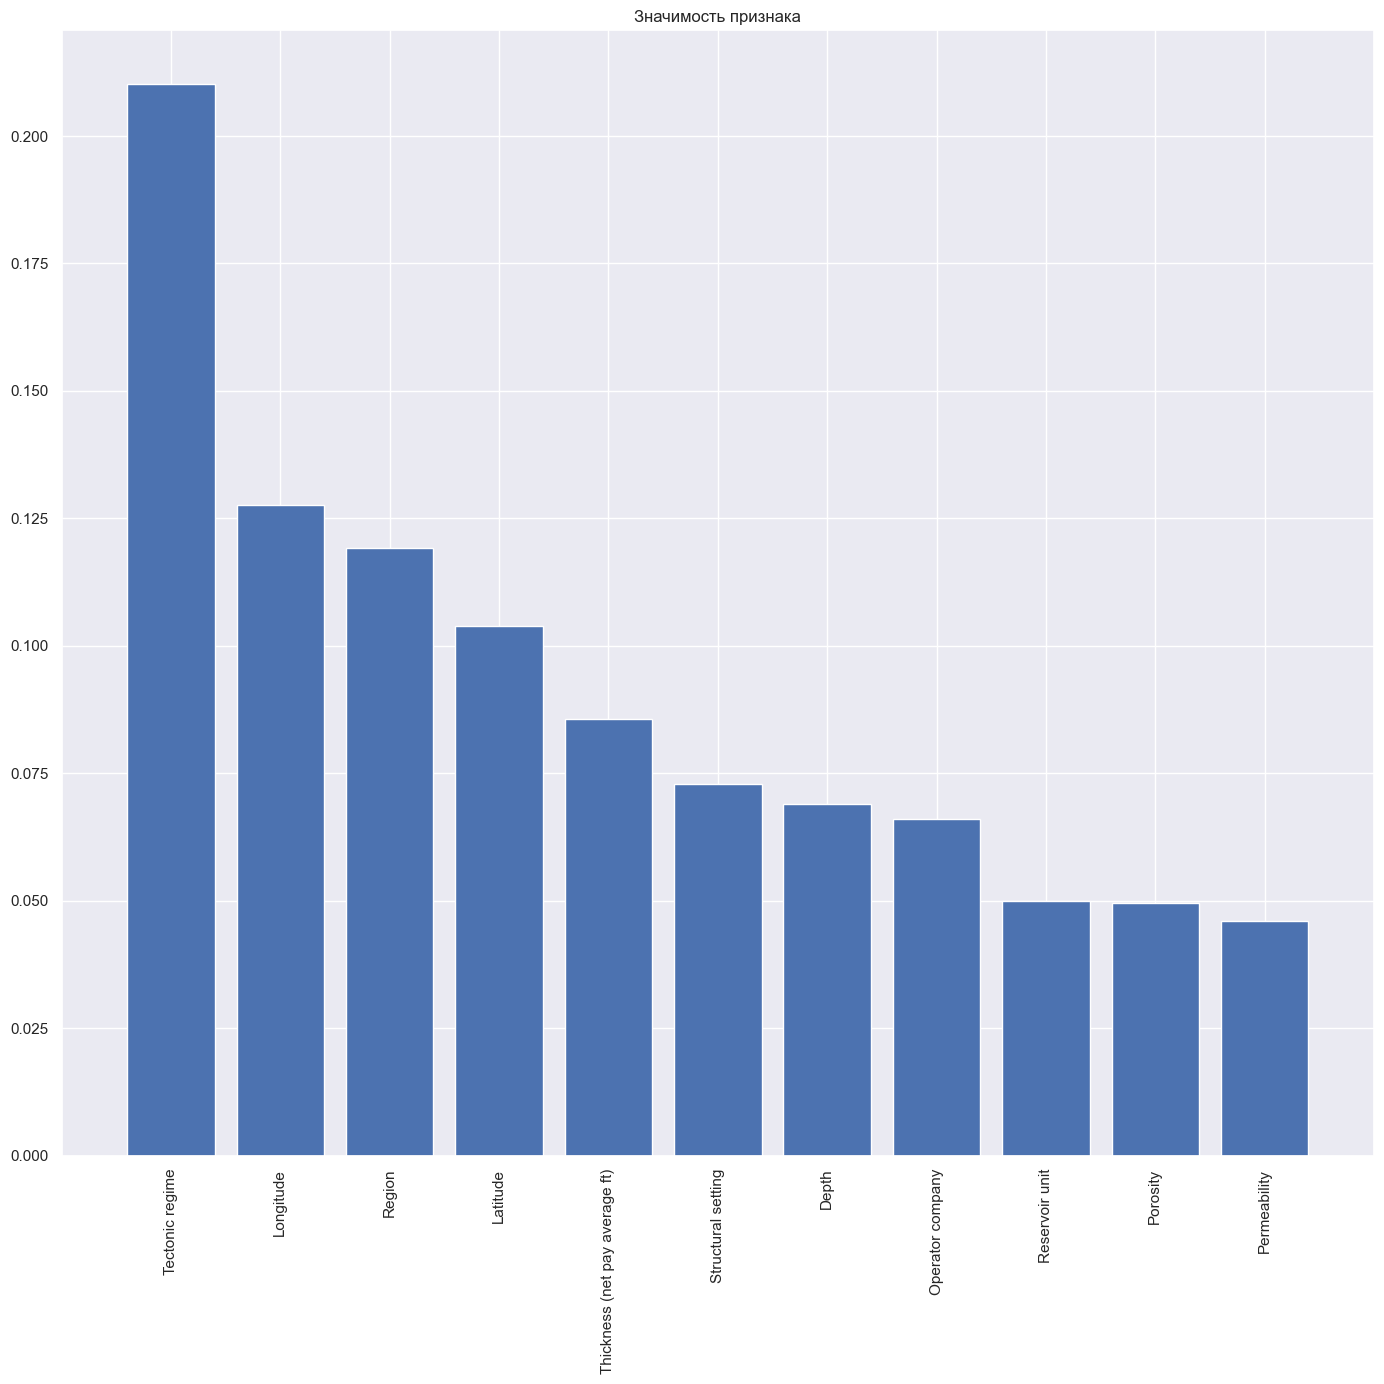

In [ ]:
# Осуществить оценку важности признаков с помощью RandomForest
feat_labels = train_df.columns[:-1]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Значимость признака')
plt.bar(range(X.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (214, 11), (214,)
Train dataset size: (54, 11), (54,)


In [ ]:
# Создадим модель дерева решений
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(2)
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    learning_rate=0.01,
    max_depth=6,
    n_estimators=1000,
    random_state=42
)

# обучение модели
tree.fit(X_train, y_train)
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# предсказание ответов для тестовой выборки
y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_forest = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy tree: {accuracy_score(y_test, y_pred_tree)}')
print(f'Accuracy knn: {accuracy_score(y_test, y_pred_knn)}')
print(f'Accuracy rf: {accuracy_score(y_test, y_pred_forest)}')
print(f'Accuracy xgb: {accuracy_score(y_test, y_pred_xgb)}')

Accuracy tree: 0.8333333333333334
Accuracy knn: 0.6296296296296297
Accuracy rf: 0.8333333333333334
Accuracy xgb: 0.8148148148148148


In [ ]:
tree = DecisionTreeClassifier(criterion='gini',
                              random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree, average='weighted')
print(f'Accuracy DecisionTree: {f1:.3f}')
print(f'f1-score DecisionTree: {f1:.3f}')

Accuracy DecisionTree: 0.796
f1-score DecisionTree: 0.796


In [ ]:
forest_train = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                random_state=42,
                                n_jobs=2)
forest_train.fit(X_train, y_train)
y_pred_forest = forest_train.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_forest)
f1 = f1_score(y_test, y_pred_forest, average='weighted')
print(f'Accuracy RandomForest: {f1:.3f}')
print(f'f1-score RandomForest: {f1:.3f}')

Accuracy RandomForest: 0.823
f1-score RandomForest: 0.823


In [ ]:
knn = KNeighborsClassifier(n_neighbors=15, p=1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn, average='weighted')
print(f'Accuracy kNN: {f1:.3f}')
print(f'f1-score kNN: {f1:.3f}')

Accuracy kNN: 0.679
f1-score kNN: 0.679


In [ ]:
model = xgb.XGBClassifier(n_estimators=1000, 
                          learning_rate=0.01, 
                          max_depth=6, 
                          random_state=1)
gbm = model.fit(X_train, y_train)
y_pred_xgb = gbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f'Accuracy XGboost: {f1:.3f}')
print(f'f1-score XGboost: {f1:.3f}')

Accuracy XGboost: 0.802
f1-score XGboost: 0.802


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    learning_rate=0.01,
    max_depth=6,
    n_estimators=1000,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f'Accuracy XGboost: {f1:.3f}')
print(f'f1-score XGboost: {f1:.5f}')

Accuracy XGboost: 0.802
f1-score XGboost: 0.80211


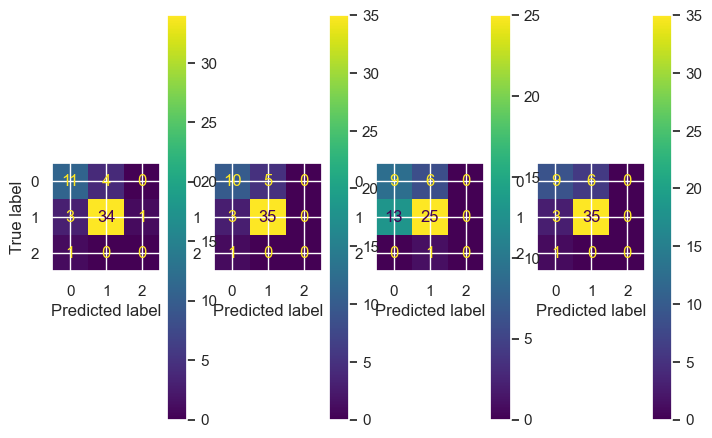

In [ ]:
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, axes = plt.subplots(1, 4, figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix_tree, display_labels=tree.classes_)
display.plot(ax=axes[0])
display = ConfusionMatrixDisplay(conf_matrix_forest, display_labels=forest.classes_)
display.plot(ax=axes[1])
display = ConfusionMatrixDisplay(conf_matrix_knn, display_labels=knn.classes_)
display.plot(ax=axes[2])
display = ConfusionMatrixDisplay(conf_matrix_xgb, display_labels=xgb.classes_)
display.plot(ax=axes[3])

In [ ]:
y_test_pred = forest.predict(test_df)
ans_df = pd.DataFrame(y_test_pred, columns=['Onshore/Offshore '])

ans_df.reset_index(inplace=True)
ans_df.info()
ans_df.to_csv('submissionForest3.csv', index=False)